## Importing the libraries

In [1]:
!pip install mlxtend

In [2]:
!pip install wordcloud

In [3]:
import mlxtend
print(mlxtend.__version__)  

0.18.0


In [4]:
import seaborn as sns
import numpy as np
import pandas as pd
import networkx as nx
import pyodbc 
from wordcloud import WordCloud
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori,association_rules
import matplotlib.pyplot as plt

## Load the Dataset

In [5]:
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=DESKTOP-A6QRAK4;"
                       "Database=AdventureWorks2012;"
                      "Trusted_Connection=yes;")

dataset = pd.read_sql_query(
'''SELECT 
A.[SalesOrderID]
,A.[OrderQty]
,C.[Name] AS ProductSubCat
,E.[Name] AS Location
,AVG(A.[UnitPrice]) * A.[OrderQty] AS Sales_Revenue
,AVG(A.[UnitPrice]) AS AVG_Price
,CASE WHEN D.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'In Store' END AS Sales_Channel
FROM  [Sales].[SalesOrderDetail] AS A
LEFT JOIN [Production].[Product] AS B 
ON A.[ProductID] = B.[ProductID]
LEFT JOIN [Production].[ProductSubcategory] AS C
ON B.[ProductSubcategoryID] = C.[ProductSubcategoryID]
LEFT JOIN [Sales].[SalesOrderHeader] AS D
ON A.[SalesOrderID] = D.[SalesOrderID]
LEFT JOIN [Sales].[SalesTerritory] AS E
ON D.[TerritoryID] = E.[TerritoryID]
WHERE D.[OnlineOrderFlag] = 1
GROUP BY A.[SalesOrderID],A.[OrderQty],A.[LineTotal],C.[Name],E.[Name],D.[OnlineOrderFlag]
ORDER BY A.[SalesOrderID],A.[OrderQty],A.[LineTotal],C.[Name],E.[Name],D.[OnlineOrderFlag]''', cnxn)

print(dataset)

       SalesOrderID  OrderQty   ProductSubCat   Location  Sales_Revenue  \
0             43697         1      Road Bikes     Canada      3578.2700   
1             43698         1  Mountain Bikes     France      3399.9900   
2             43699         1  Mountain Bikes  Northwest      3399.9900   
3             43700         1      Road Bikes  Southwest       699.0982   
4             43701         1  Mountain Bikes  Australia      3399.9900   
...             ...       ...             ...        ...            ...   
60393         75122         1            Caps     Canada         8.9900   
60394         75122         1         Fenders     Canada        21.9800   
60395         75123         1            Caps     Canada         8.9900   
60396         75123         1         Fenders     Canada        21.9800   
60397         75123         1     Bike Stands     Canada       159.0000   

       AVG_Price Sales_Channel  
0      3578.2700        Online  
1      3399.9900        Online  


In [6]:
dataset.shape

(60398, 7)

## Data Cleaning

In [7]:
dataset['ProductSubCat'] = dataset['ProductSubCat'].str.strip() ## Remove Spaces
dataset.dropna(axis=0, subset=['SalesOrderID'], inplace=True) ## Remove Duplicates
dataset['SalesOrderID'] = dataset['SalesOrderID'].astype('str') ## Change to String
dataset

,SalesOrderID,OrderQty,ProductSubCat,Location,Sales_Revenue,AVG_Price,Sales_Channel
0,43697,1,Road Bikes,Canada,3578.2700,3578.2700,Online
1,43698,1,Mountain Bikes,France,3399.9900,3399.9900,Online
2,43699,1,Mountain Bikes,Northwest,3399.9900,3399.9900,Online
3,43700,1,Road Bikes,Southwest,699.0982,699.0982,Online
4,43701,1,Mountain Bikes,Australia,3399.9900,3399.9900,Online
...,...,...,...,...,...,...,...
60393,75122,1,Caps,Canada,8.9900,8.9900,Online
60394,75122,1,Fenders,Canada,21.9800,21.9800,Online
60395,75123,1,Caps,Canada,8.9900,8.9900,Online
60396,75123,1,Fenders,Canada,21.9800,21.9800,Online


In [8]:
dataset['Sales_Channel'].value_counts()

Online    60398
Name: Sales_Channel, dtype: int64

In [9]:
## Separating transactions for Countries
basket=(dataset[dataset['Sales_Channel']=="Online"]
         .groupby(['SalesOrderID','ProductSubCat'])['OrderQty']
         .sum().unstack().reset_index().fillna(0)
         .set_index('SalesOrderID'))
basket  ## Viewing transaction basket

ProductSubCat,Bike Racks,Bike Stands,Bottles and Cages,Caps,Cleaners,Fenders,Gloves,Helmets,Hydration Packs,Jerseys,Mountain Bikes,Road Bikes,Shorts,Socks,Tires and Tubes,Touring Bikes,Vests
SalesOrderID,,,,,,,,,,,,,,,,,
43697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
43699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
43700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
75120,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [10]:
## Convert dataset into 1-0 encoding

def encode_units(x):
    if x == False:
        return 0
    if x == True:
        return 1
    
basket_sets = basket.applymap(encode_units)
basket_sets

ProductSubCat,Bike Racks,Bike Stands,Bottles and Cages,Caps,Cleaners,Fenders,Gloves,Helmets,Hydration Packs,Jerseys,Mountain Bikes,Road Bikes,Shorts,Socks,Tires and Tubes,Touring Bikes,Vests
SalesOrderID,,,,,,,,,,,,,,,,,
43697,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0.0,0,0
43698,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0
43699,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0
43700,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0.0,0,0
43701,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75119,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0
75120,0,0,0.0,1,0,1,0,0,0,1,0,0,0,0,0.0,0,0
75121,0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,NaN,0,0


In [11]:
basket_sets=basket_sets.dropna()

## Algorithm Implemention

In [12]:
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)## Generating Frequent Itemsets
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1) ## Generating rules
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Jerseys),(Caps),0.135692,0.082258,0.025159,0.185409,2.254003,0.013997,1.126630
1,(Caps),(Jerseys),0.082258,0.135692,0.025159,0.305851,2.254003,0.013997,1.245133
2,(Helmets),(Fenders),0.205644,0.087563,0.024830,0.120745,1.378948,0.006824,1.037739
3,(Fenders),(Helmets),0.087563,0.205644,0.024830,0.283573,1.378948,0.006824,1.108774
4,(Mountain Bikes),(Fenders),0.199683,0.087563,0.038285,0.191728,2.189607,0.020800,1.128874


## Making Recommendations

In [13]:
basket_sets['Tires and Tubes'].sum()

3457.0

In [14]:
basket_sets['Helmets'].sum()  ## Anytime this product is bought, we can also sell Mountain Bottle Cage along with it

3760

In [15]:
## Filtering rules based on condition
rules[ (rules['lift'] >=1) &
        (rules['confidence'] >= 0.05)]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Jerseys),(Caps),0.135692,0.082258,0.025159,0.185409,2.254003,0.013997,1.126630
1,(Caps),(Jerseys),0.082258,0.135692,0.025159,0.305851,2.254003,0.013997,1.245133
2,(Helmets),(Fenders),0.205644,0.087563,0.024830,0.120745,1.378948,0.006824,1.037739
3,(Fenders),(Helmets),0.087563,0.205644,0.024830,0.283573,1.378948,0.006824,1.108774
4,(Mountain Bikes),(Fenders),0.199683,0.087563,0.038285,0.191728,2.189607,0.020800,1.128874
5,(Fenders),(Mountain Bikes),0.087563,0.199683,0.038285,0.437227,2.189607,0.020800,1.422095
6,(Tires and Tubes),(Helmets),0.189072,0.205644,0.049005,0.259184,1.260352,0.010123,1.072272
7,(Helmets),(Tires and Tubes),0.205644,0.189072,0.049005,0.238298,1.260352,0.010123,1.064626
8,(Touring Bikes),(Helmets),0.078156,0.205644,0.037957,0.485654,2.361623,0.021884,1.544400
9,(Helmets),(Touring Bikes),0.205644,0.078156,0.037957,0.184574,2.361623,0.021884,1.130507


In [16]:
rules['antecedents'].value_counts()

(Helmets)            3
(Fenders)            2
(Tires and Tubes)    1
(Caps)               1
(Touring Bikes)      1
(Mountain Bikes)     1
(Jerseys)            1
Name: antecedents, dtype: int64

## Visualization

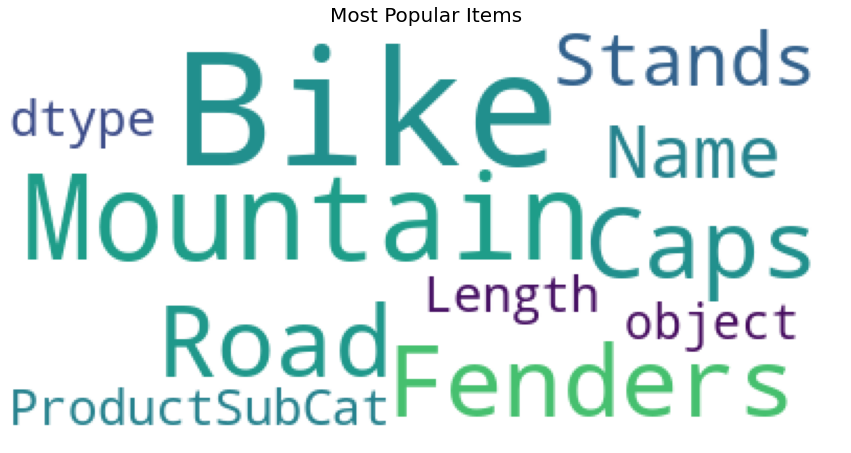

In [17]:
plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white',  max_words = 121).generate(str(dataset['ProductSubCat']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Items',fontsize = 20)
plt.show()

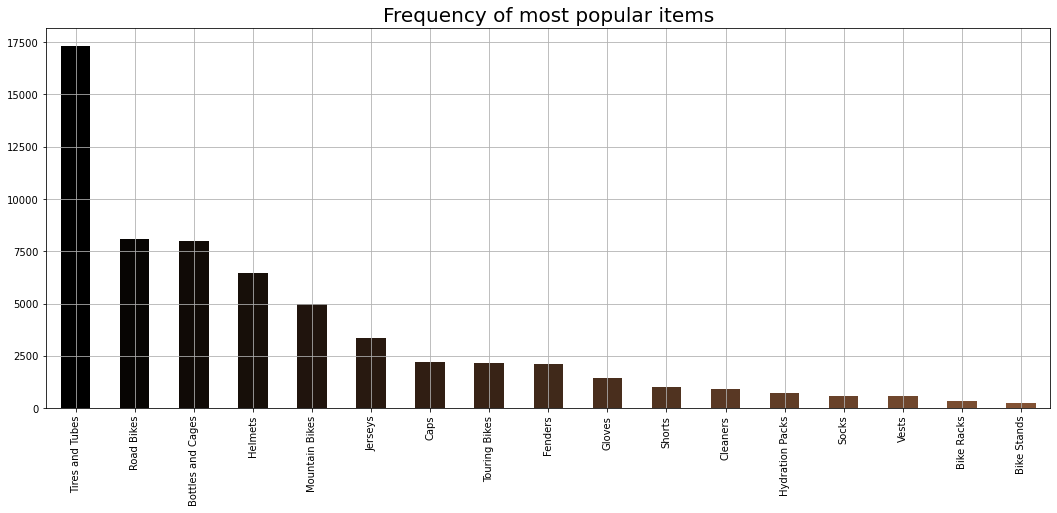

In [18]:
#barchart

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 40))
dataset['ProductSubCat'].value_counts().head(40).plot.bar(color = color)
plt.title('Frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()